# **AARON'S NIGHTMARE EQUATIONS**

## **Install**

### Firedrake

In [83]:
try:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh" -O "/tmp/firedrake-install.sh"
    !bash "/tmp/firedrake-install.sh"
    from firedrake import *  # noqa: F401
except:
    from firedrake import *  # noqa: F401

--2025-11-04 21:35:46--  https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4767 (4.7K) [application/x-sh]
Saving to: ‘/tmp/firedrake-install.sh’

/tmp/firedrake-inst 100%[===================>]   4.66K  --.-KB/s    in 0s      

2025-11-04 21:35:47 (39.9 MB/s) - ‘/tmp/firedrake-install.sh’ saved [4767/4767]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FIREDRAKE_INSTALLED=/usr/local/share/fem-on-colab/firedrake.installed
+ [[ ! -f /usr/local/share/fem-on-colab/firedrake.installed ]]
+ set +x
























#############################################################

### Irksome

In [84]:
try:
    !python3 -m pip install --no-dependencies git+https://github.com/firedrakeproject/Irksome.git
    from irksome import *  # noqa: F401
except:
    from irksome import *  # noqa: F401

  Cloning https://github.com/firedrakeproject/Irksome.git to /tmp/pip-req-build-cik7feo3
  Running command git clone --filter=blob:none --quiet https://github.com/firedrakeproject/Irksome.git /tmp/pip-req-build-cik7feo3
  Resolved https://github.com/firedrakeproject/Irksome.git to commit ac79b1c54a49933aaed752987d7982c1d7cbc547
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### Other

In [85]:
import math
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path
from typing import Dict, List, Union
from scipy import special
from mpl_toolkits.mplot3d import Axes3D

## **General functions**

### Time integrals

In [86]:
from operator import mul
from functools import reduce
import numpy
from firedrake import Function, FunctionSpace, VectorSpaceBasis, MixedVectorSpaceBasis, Constant, split
from ufl.algorithms.analysis import extract_type
from ufl.measure import Measure, MeasureSum, integral_type_to_measure_name, measure_name_to_integral_type
from ufl import as_tensor, zero
from ufl import replace as ufl_replace
from pyop2.types import MixedDat

from irksome.deriv import TimeDerivative
from irksome.labeling import TimeQuadratureLabel


def unique_mesh(mesh):
    try:
        mesh, = set(mesh)
    except TypeError:
        pass
    return mesh


def dot(A, B):
    return numpy.tensordot(A, B, (-1, 0))


def reshape(expr, shape):
    return numpy.reshape([expr[i] for i in numpy.ndindex(expr.ufl_shape)], shape)


def flatten_dats(dats):
    flat_dat = []
    for dat in dats:
        if isinstance(dat, (tuple, list, MixedDat)):
            flat_dat.extend(dat)
        else:
            flat_dat.append(dat)
    return MixedDat(flat_dat)


def get_stage_space(V, num_stages):
    return reduce(mul, (V for _ in range(num_stages)))


def getNullspace(V, Vbig, num_stages, nullspace):
    """
    Computes the nullspace for a multi-stage method.

    :arg V: The :class:`FunctionSpace` on which the original time-dependent PDE is posed.
    :arg Vbig: The multi-stage :class:`FunctionSpace` for the stage problem
    :arg num_stages: The number of stages in the RK method
    :arg nullspace: The nullspace for the original problem.

    On output, we produce a :class:`MixedVectorSpaceBasis` defining the nullspace
    for the multistage problem.
    """

    num_fields = len(V)
    if nullspace is None:
        nspnew = None
    else:
        if isinstance(nullspace, (MixedVectorSpaceBasis, VectorSpaceBasis)):
            nullspace = [(field, basis) for field, basis in enumerate(nullspace)
                         if isinstance(basis, VectorSpaceBasis)]
        try:
            nullspace.sort()
        except AttributeError:
            raise AttributeError("Nullspace entries must be of form (idx, VSP), where idx is a non-negative integer")
        if (nullspace[-1][0] > num_fields) or (nullspace[0][0] < 0):
            raise ValueError("At least one index for nullspaces is out of range")
        nspnew = []
        nsp_comp = len(nullspace)
        for i in range(num_stages):
            count = 0
            for j in range(num_fields):
                if count < nsp_comp and j == nullspace[count][0]:
                    nspnew.append(nullspace[count][1])
                    count += 1
                else:
                    nspnew.append(Vbig.sub(j + num_fields * i))
        nspnew = MixedVectorSpaceBasis(Vbig, nspnew)

    return nspnew


def replace(e, mapping):
    """A wrapper for ufl.replace that allows numpy arrays."""
    cmapping = {k: as_tensor(v) for k, v in mapping.items()}
    return ufl_replace(e, cmapping)


def replace_auxiliary_variables(F, u0, aux_indices):
    """Discretize the fields corresponding to aux_indices in Dt(V)."""
    if aux_indices is None:
        return F

    components = []
    for i, usub in enumerate(split(u0)):
        if i in aux_indices:
            usub = TimeDerivative(usub)
        components.extend(usub[i] for i in numpy.ndindex(usub.ufl_shape))
    return replace(F, {u0: numpy.reshape(components, u0.ufl_shape)})


# Utility functions that help us refactor
def AI(A):
    return (A, numpy.eye(*A.shape, dtype=A.dtype))


def IA(A):
    return (numpy.eye(*A.shape, dtype=A.dtype), A)


def is_ode(f, u):
    """Given a form defined over a function `u`, checks if
    (each bit of) u appears under a time derivative."""
    derivs = extract_type(f, TimeDerivative)
    Dtbits = []
    for k in derivs:
        op, = k.ufl_operands
        Dtbits.extend(op[i] for i in numpy.ndindex(op.ufl_shape))
    ubits = [u[i] for i in numpy.ndindex(u.ufl_shape)]
    return set(Dtbits) == set(ubits)


# Utility class for constants on a mesh
class MeshConstant(object):
    def __init__(self, msh):
        self.msh = unique_mesh(msh)
        self.V = FunctionSpace(self.msh, 'R', 0)

    def Constant(self, val=0.0):
        return Function(self.V).assign(val)


def ConstantOrZero(x, MC=None):
    const = MC.Constant if MC else Constant
    return zero() if abs(complex(x)) < 1.e-10 else const(x)


vecconst = numpy.vectorize(ConstantOrZero)


# Measure for space-time integration with Galerkin-in-time
class TimeMeasure(Measure):
    """Representation of a space-time integration measure.
    """

    # Only declare new attributes introduced in this subclass.
    # Parent Measure already defines slots for domain/integral/metadata/etc.
    __slots__ = ("time_degree", "quad_rule", "space_measure")

    def __init__(
        self,
        integral_type,  # "dx" etc
        time_degree,
        domain=None,
        subdomain_id="everywhere",
        metadata=None,
        subdomain_data=None,
    ):
        """Initialise.

        Args:
            integral_type: one of "cell", etc, or short form "dx", etc
            time_degree: degree of time quadrature
            domain: an AbstractDomain object (most often a Mesh)
            subdomain_id: either string "everywhere", a single subdomain id int, or tuple of ints
            metadata: dict, with additional compiler-specific parameters
                affecting how code is generated, including parameters
                for optimization or debugging of generated code
            subdomain_data: object representing data to interpret subdomain_id with
        """
        self.time_degree = time_degree
        self.quad_rule = TimeQuadratureLabel(time_degree)
        self.space_measure = Measure(
            integral_type,
            domain=domain,
            subdomain_id=subdomain_id,
            metadata=metadata,
            subdomain_data=subdomain_data
        )
        super().__init__(
            integral_type,
            domain=domain,
            subdomain_id=subdomain_id,
            metadata=metadata,
            subdomain_data=subdomain_data
        )

    def __add__(self, other):
        """Add two measures (self+other).

        Creates an intermediate object used for the notation
          expr * (dx(1) + dx(2)) := expr * dx(1) + expr * dx(2)
        """
        if isinstance(other, TimeMeasure):
            # Let dx(1) + dx(2) equal dx((1,2))
            return TimeMeasureSum(self, other)
        else:
            # Can only add Measures
            return NotImplemented

    def __mul__(self, other):
        """Multiply two space-time measures (self*other).

        Not yet functional.
        """
        return NotImplemented

    def __rmul__(self, integrand):
        """Multiply a scalar expression with measure to construct a form with a single integral.
        """
        return self.quad_rule(integrand * self.space_measure)

class TimeMeasureSum(MeasureSum):
    """Represents a sum of space-time measures.
    """

    def __init__(self, *measures):
        """Initialise."""
        super().__init__(*measures)

    def __add__(self, other):
        """Add."""
        if isinstance(other, TimeMeasure):
            return TimeMeasureSum(*(self._measures + (other,)))
        elif isinstance(other, TimeMeasureSum):
            return TimeMeasureSum(*(self._measures + other._measures))
        return NotImplemented

def _make_time_measure_function(name, integral_type):
    """Convert integral type into function
    """
    # e.g. name="dx", integral_type="cell"
    def _f(time_degree, domain=None, subdomain_id="everywhere",
           metadata=None, subdomain_data=None):
        return TimeMeasure(
            integral_type=integral_type,
            time_degree=time_degree,
            domain=domain,
            subdomain_id=subdomain_id,
            metadata=metadata,
            subdomain_data=subdomain_data
        )
    _f.__name__ = f"{name}_time"
    return _f

for _name, _itype in measure_name_to_integral_type.items():
    """Export all time-measure functions into the module namespace
    """
    globals()[f"{_name}_time"] = _make_time_measure_function(_name, _itype)


### Nonlinear Schrödinger: Energy

In [103]:
def nls(
    N:           int = 2**7,
    deg:         int = 1,
    time_degree: int = 1,
    Nt:          int = 2**9,
    dt:          Union[int, float] = 1.0,
    L:           Union[int, float] = 2**6,
    speed:       Union[int, float] = 0.0,
    eta:         Union[int, float] = 1.0,
    x0:          Union[int, float] = 2**5,
    scheme:      str = "cpg",
    output_dir:  str = "output/nls/",
    write_qois:  bool = False,
    write_vtk:   bool = False,
    show_plot:   bool = False,
) -> Dict[str, List[float]]:
    """
    1D nonlinear Schrödinger equation with standard continuous Petrov-Galerkin (energy-conserving).

    Returns
    - Dictionary: {"time": [...], "mass": [...], "momentum": [...], "energy": [...]}
    """

    # Ensure output directory exists
    out_path = Path(output_dir)
    out_path.mkdir(parents=True, exist_ok=True)

    # Convert parameters to UFL objects
    dt_c = Constant(dt)
    speed_c = Constant(speed)
    eta_c = Constant(eta)
    x0_c = Constant(x0)

    # Mesh and coordinates (interval)
    mesh = PeriodicIntervalMesh(N, L)
    x, = SpatialCoordinate(mesh)

    # Function spaces and functions
    V = FunctionSpace(mesh, "CG", deg)
    Z = V * V
    psi = Function(Z, name="state")
    a, b = split(psi)
    a_out, b_out = psi.subfunctions
    v, w = TestFunctions(Z)

    # Initial condition (soliton)
    amp = eta_c / cosh(eta_c * (x - x0_c))
    phase = speed_c * x
    a_ic = amp * cos(phase); b_ic = amp * sin(phase)
    psi.project(as_vector([a_ic, b_ic]))

    # Residual
    amp_squared = a**2 + b**2
    F = (
        (  # Real
            inner(Dt(b), v)
          + 0.5 * inner(grad(a), grad(v))
          - inner(amp_squared * a, v)
        )
      + (  # Imaginary
          - inner(Dt(a), w)
          + 0.5 * inner(grad(b), grad(w))
          - inner(amp_squared * b, w)
        )
    ) * dx

    # Quantities of interest
    M = amp_squared * dx
    P = (a * b.dx(0) - b * a.dx(0)) * dx
    E = 0.5 *(inner(grad(a), grad(a)) + inner(grad(b), grad(b)) - amp_squared**2) * dx

    # Time stepper
    t = Constant(0.0)
    sp = {
        # "snes_rtol": 1.0e-12,
        # "snes_atol": 1.0e-14,
        # "snes_max_it": 50,
        # # "snes_converged_reason": None,
        # # "snes_linesearch_monitor": None,
        # # "snes_monitor": None,
        # "ksp_type": "gmres",
        # "ksp_rtol": 1.0e-12,
        # "ksp_atol": 1.0e-14,
        # "pc_type": "lu",
        # "pc_factor_mat_solver_type": "mumps",
    }
    scheme_dict = {
        "cpg"   : ContinuousPetrovGalerkinScheme(time_degree, quadrature_degree=4*time_degree-1),
        "gauss" : GaussLegendre(time_degree)
    }
    stepper = TimeStepper(F, scheme_dict[scheme.lower()], t, dt_c, psi, solver_parameters=sp)


    # Set up outputs
    t_arr: List[float] = []
    M_arr: List[float] = []
    P_arr: List[float] = []
    E_arr: List[float] = []
    if write_qois:
        qoi_path = out_path / "qois.csv"
        with qoi_path.open("w", encoding="utf-8") as f:
            f.write("time,mass,momentum,energy\n")

    if write_vtk:
        vtk = VTKFile(str(out_path / "psi_mag.pvd"))
        a_out.rename("Real part (Re(psi))"); b_out.rename("Imaginary part (Im(psi))")
        vtk.write(a_out, b_out, time=float(t))

    def record_and_log():
        t_out = float(t)
        M_out = float(assemble(M))
        P_out = float(assemble(P))
        E_out = float(assemble(E))
        print(BLUE % f"Time (t): {t_out}")
        print(GREEN % f"\tMass:     {M_out}")
        print(GREEN % f"\tMomentum: {P_out}")
        print(GREEN % f"\tEnergy:   {E_out}")
        t_arr.append(t_out)
        M_arr.append(M_out)
        P_arr.append(P_out)
        E_arr.append(E_out)
        if write_qois:
            with qoi_path.open("a", encoding="utf-8") as f:
                f.write(f"{t_out},{M_out},{P_out},{E_out}\n")

    record_and_log()

    # Time loop
    for _ in range(Nt):
        stepper.advance()
        t.assign(float(t) + float(dt_c))
        if write_vtk: vtk.write(a_out, b_out, time=float(t))
        record_and_log()

    # Show plot
    if show_plot:
        fig = plt.figure()
        ax = fig.add_subplot(projection="3d")
        ax.plot(np.linspace(0.0, (1-1/N)*L, N), *psi.dat.data)
        ax.set_box_aspect([2.0, 1.0, 1.0])
        ax.set_ylim3d(-1, 1); ax.set_zlim3d(-1, 1)
        plt.show()

    return {"time": t_arr, "mass": M_arr, "momentum": P_arr, "energy": E_arr}

Time (t): 0.0
	Mass:     1.9992288130599212
	Momentum: 1.9930567551290872
	Energy:   0.7393654180388988
Time (t): 1.0
	Mass:     1.9999628606592097
	Momentum: 1.991194577055132
	Energy:   0.7393654180381257
Time (t): 2.0
	Mass:     2.001057140521392
	Momentum: 1.9867629835500487
	Energy:   0.7393654180374809
Time (t): 3.0
	Mass:     2.0014544448351135
	Momentum: 1.9804961100242215
	Energy:   0.7393654180370344
Time (t): 4.0
	Mass:     2.0009810654571814
	Momentum: 1.9728345302578338
	Energy:   0.739365418036719
Time (t): 5.0
	Mass:     1.9997276727321944
	Momentum: 1.9642495461793081
	Energy:   0.7393654180364817
Time (t): 6.0
	Mass:     1.9978380646177496
	Momentum: 1.9551631186095602
	Energy:   0.7393654180362901
Time (t): 7.0
	Mass:     1.9954552297704289
	Momentum: 1.9459044325840609
	Energy:   0.7393654180361224
Time (t): 8.0
	Mass:     1.9927129356538376
	Momentum: 1.9366952614081536
	Energy:   0.7393654180359637
Time (t): 9.0
	Mass:     1.9897393890316466
	Momentum: 1.9276487627

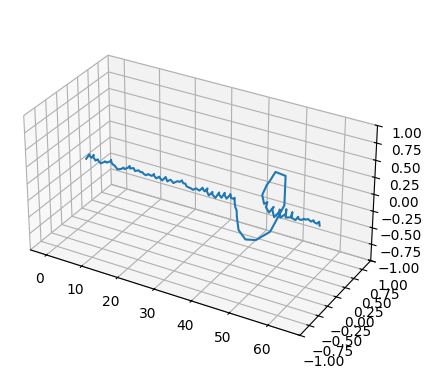

In [127]:
_ = nls(scheme="cpg", show_plot=True, Nt=2**10, speed=1.0)

Time (t): 0.0
	Mass:     1.9992288130599212
	Momentum: 1.9930567551290872
	Energy:   0.7393654180388988
Time (t): 1.0
	Mass:     1.9992288130599065
	Momentum: 1.9929516828575695
	Energy:   0.7427997869027657
Time (t): 2.0
	Mass:     1.9992288130520888
	Momentum: 1.9926338582321304
	Energy:   0.7519717265258237
Time (t): 3.0
	Mass:     1.9992288130462417
	Momentum: 1.9921082073601954
	Energy:   0.7647273288484567
Time (t): 4.0
	Mass:     1.9992288130418636
	Momentum: 1.9914293316607168
	Energy:   0.7795676207030798
Time (t): 5.0
	Mass:     1.9992288130381604
	Momentum: 1.9906504874315063
	Energy:   0.7954438404888634
Time (t): 6.0
	Mass:     1.9992288130346663
	Momentum: 1.9898144409899952
	Energy:   0.8115891721337709
Time (t): 7.0
	Mass:     1.9992288130311173
	Momentum: 1.9889538497774248
	Energy:   0.8274614612851399
Time (t): 8.0
	Mass:     1.9992288130273652
	Momentum: 1.9880921708493031
	Energy:   0.8427224638055448
Time (t): 9.0
	Mass:     1.9992288130233322
	Momentum: 1.9872438

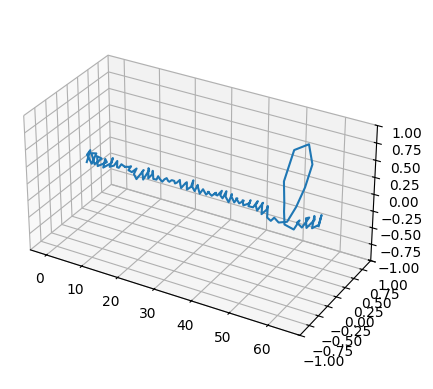

In [128]:
_ = nls(scheme="gauss", show_plot=True, Nt=2**10, speed=1.0)

### Incompressible Navier-Stokes: Energy/Helicity

In [ ]:
# Firedrake-compatible Bessel function
def besselJ(x, alpha, layers=10):
    return sum([
        (-1)**m / math.factorial(m) / special.gamma(m + alpha + 1)
      * (x/2)**(2*m+alpha)
        for m in range(layers)
    ])



# Bessel function parameters
besselJ_root = 5.7634591968945506
besselJ_root_threehalves = besselJ(besselJ_root, 3/2)



# (r, theta, phi) components of Hill vortex
def hill_r(r, theta, radius):
    rho = r / radius
    return 2 * (
        besselJ(besselJ_root*rho, 3/2) / rho**(3/2)
      - besselJ_root_threehalves
    ) * cos(theta)

def hill_theta(r, theta, radius):
    rho = r / radius
    return (
        besselJ_root * besselJ(besselJ_root*rho, 5/2) / rho**(1/2)
      + 2 * besselJ_root_threehalves
      - 2 * besselJ(besselJ_root*rho, 3/2) / rho**(3/2)
    ) * sin(theta)

def hill_phi(r, theta, radius):
    rho = r / radius
    return besselJ_root * (
        besselJ(besselJ_root*rho, 3/2) / rho**(3/2)
      - besselJ_root_threehalves
    ) * rho * sin(theta)



# Hill vortex (Cartesian)
def hill(vec, radius):
    (x, y, z) = vec

    # Cylindrical/spherical coordinates
    r_cyl = sqrt(x**2 + y**2)  # Cylindrical radius
    r_sph = sqrt(x**2 + y**2 + z**2)  # Spherical radius
    theta = conditional(  # Spherical angle
        le(r_cyl, 1e-13),
        0,
        pi/2 - atan(z/r_cyl)
    )

    return conditional(  # If we're outside the vortex...
        ge(r_sph, radius),
        as_vector([0, 0, 0]),
        conditional(  # If we're at the origin...
            le(r_sph, 1e-13),
            as_vector([0, 0, 2*((besselJ_root/2)**(3/2)/special.gamma(5/2) - besselJ_root_threehalves)]),
            conditional(  # If we're on the z axis...
                le(r_cyl, 1e-13),
                as_vector([0, 0, hill_r(r_sph, 0, radius)]),
                as_vector(  # Else...
                    hill_r(r_sph, theta, radius) * np.array([x, y, z]) / r_sph
                  + hill_theta(r_sph, theta, radius) * np.array([x*z, y*z, -r_cyl**2]) / r_sph / r_cyl
                  + hill_phi(r_sph, theta, radius) * np.array([-y, x, 0]) / r_cyl
                )
            )
        )
    )



# Solver
def ns_helicity(
    Re:         Union[int, float] = 2**16,
    N:          int = 8,
    deg:        int = 1,
    time_deg:   int = 1,
    Nt:         int = 48,
    dt:         Union[int, float] = 2**-10,
    output_dir: str = "output/ns_helicity/",
    write_qois: bool = False,
    write_vtk:  bool = False,
) -> Dict[str, List[float]]:
    """
    Energy- and helicity-preserving continuous Petrov-Galerkin Navier-Stokes scheme.

    Returns
    - Dictionary: {"time": [...], "Q1": [...], "Q2": [...]}
    """

    # Ensure output directory exists
    out_path = Path(output_dir)
    out_path.mkdir(parents=True, exist_ok=True)

    # Convert parameters to UFL objects
    Re_c = Constant(Re)
    dt_c = Constant(dt)

    # Mesh and coordinates (3D periodic box)
    mesh = PeriodicUnitCubeMesh(N, N, N)
    x, y, z = SpatialCoordinate(mesh)

    # Function spaces and functions
    V = VectorFunctionSpace(mesh, "CG", deg + 1)
    Q = FunctionSpace(mesh, "CG", deg)
    R = FunctionSpace(mesh, "R", 0)
    Z = V * Q * R * R * R * V * V * Q * R * R * R  # Mixed space: (u, p, lam_u, utilde, wtilde, theta, lam_w)
    up = Function(Z, name="state")
    u, p, lam_u_0, lam_u_1, lam_u_2, utilde, wtilde, theta, lam_wtilde_0, lam_wtilde_1, lam_wtilde_2 = split(up)
    lam_u = (lam_u_0, lam_u_1, lam_u_2); lam_wtilde = (lam_wtilde_0, lam_wtilde_1, lam_wtilde_2)
    u_out, p_out, lam_u_0_out, lam_u_1_out, lam_u_2_out, utilde_out, wtilde_out, _, _, _, _ = up.subfunctions
    lam_u_out = (lam_u_0_out, lam_u_1_out, lam_u_2_out)
    v, q, mu_v_0, mu_v_1, mu_v_2, vtilde1, vtilde2, eta, mu_vtilde2_0, mu_vtilde2_1, mu_vtilde2_2 = TestFunctions(Z)
    mu_v = (mu_v_0, mu_v_1, mu_v_2); mu_vtilde2 = (mu_vtilde2_0, mu_vtilde2_1, mu_vtilde2_2)

    # (Discretely) div-free projection
    def project_div_free(target):
        Z_ = V * Q * R * R * R
        up_ = Function(Z_)
        u_, p_, lam_u_0_, lam_u_1_, lam_u_2_ = split(up_)
        lam_u_ = (lam_u_0_, lam_u_1_, lam_u_2_)
        v_, q_, mu_v_0_,  mu_v_1_,  mu_v_2_  = TestFunctions(Z_)
        mu_v_ = (mu_v_0_, mu_v_1_, mu_v_2_)
        F_ = (
            inner(u_ - target, v_) * dx
          - inner(p_, div(v_)) * dx
          - sum([inner(lam_u_[i], v_[i]) for i in range(3)]) * dx
          - inner(div(u_), q_) * dx
          - sum([inner(u_[i], mu_v_[i]) for i in range(3)]) * dx
        )
        solve(F_ == 0, up_)
        return up_

    # Initial condition (scaled Hill vortex centred in the box), then div-free projection
    hh = 2 * hill([x - 0.5, y - 0.5, z - 0.5], 0.25)
    print(RED % f"Setting up ICs...")
    up0 = project_div_free(hh)
    u_out.assign(up0.subfunctions[0])
    p_out.assign(up0.subfunctions[1])
    for i in range(3): lam_u_out[i].assign(up0.subfunctions[2+i])
    utilde_out.assign(up0.subfunctions[0])
    wtilde_out.interpolate(curl(hh))

    # Continuous Petrov-Galerkin residual
    dx_time_2     = dx_time(time_deg=2*time_deg)
    dx_time_2plus = dx_time(time_deg=2*time_deg+1)
    dx_time_3     = dx_time(time_deg=3*time_deg)
    F = (
        (  # Momentum
            inner(Dt(u), v) * dx_time_2
          - inner(cross(utilde, wtilde), v) * dx_time_3
          + 1/Re_c * inner(grad(utilde), grad(v)) * dx_time_2
          - inner(p, div(v)) * dx_time_2
          - sum([inner(lam_u[i], v[i]) for i in range(3)]) * dx_time_2
        )
      + (  # Mass
          - inner(div(u), q) * dx_time_2plus
        )
      + (  # Stationary
          - sum([inner(u[i], mu_v[i]) for i in range(3)]) * dx_time_2plus
        )
      + (  # Auxiliary velocity
            inner(utilde, vtilde1) * dx_time_2
          - inner(u, vtilde1) * dx_time_2plus
        )
      + (  # Auxiliary vorticity
            inner(wtilde, vtilde2) * dx_time_2
          - (inner(curl(u), vtilde2) + inner(u, curl(vtilde2))) * dx_time_2plus
          - inner(theta, div(vtilde2)) * dx_time_2
          - sum([inner(lam_wtilde[i], vtilde2[i]) for i in range(3)]) * dx_time_2
        )
      + (  # Auxiliary vorticity incompressibility
          - inner(div(wtilde), eta) * dx_time_2
        )
      + (  # Auxiliary vorticity stationary
          - sum([inner(wtilde[i], mu_vtilde2[i]) for i in range(3)]) * dx_time_2plus
        )
    )

    # Quantities of interest
    Q1 = 0.5 * inner(u, u) * dx  # Energy
    Q2 = 0.5 * inner(u, curl(u)) * dx  # Helicity

    # Time integrator
    t = Constant(0.0)
    stepper = GalerkinTimeStepper(F, time_deg, t, dt_c, up, aux_indices=[1,2,3,4,5,6,7,8,9,10])

    # Set up outputs
    if write_qois:
        qoi_path = out_path / "qois.csv"
        with qoi_path.open("w", encoding="utf-8") as f:
            f.write("time,energy,helicity\n")
        t_arr: List[float] = []
        Q1_arr: List[float] = []
        Q2_arr: List[float] = []

    if write_vtk:
        vtk = VTKFile(str(out_path / "u.pvd"))
        u_out.rename("Velocity (u)")
        vtk.write(u_out, time=float(t))

    def record_and_log():
        t_out = float(t)
        Q1_out = float(assemble(Q1))
        Q2_out = float(assemble(Q2))
        print(BLUE % f"Time (t): {t_out}")
        print(GREEN % f"\tEnergy (Q1):   {Q1_out}")
        print(GREEN % f"\tHelicity (Q2): {Q2_out}")
        if write_qois:
            t_arr.append(t_out)
            Q1_arr.append(Q1_out)
            Q2_arr.append(Q2_out)
            with qoi_path.open("a", encoding="utf-8") as f:
                f.write(f"{t_out},{Q1_out},{Q2_out}\n")

    record_and_log()

    # Time loop
    for _ in range(Nt):
        stepper.advance()
        t.assign(float(t) + float(dt_c))
        if write_vtk: vtk.write(u_out, time=float(t))
        record_and_log()

    # return {"time": t_arr, "energy": Q1_arr, "helicity": Q2_arr}

In [ ]:
ns_helicity(Re=2**0, N=4, deg=1, time_deg=1, Nt=48, dt=2**-16)

firedrake:WARNING Real block detected, generating Schur complement elimination PC


Setting up ICs...


firedrake:WARNING Real block detected, generating Schur complement elimination PC


Time (t): 0.0
	Energy (Q1):   0.8173504053419052
	Helicity (Q2): 12.089860111751891


### Aaron's nightmare equations: Energy/Entropy

In [ ]:
def maxwell_stefan(
    Nspec:      int = 2,
    Nx:         int = 24,
    deg:        int = 1,
    vdeg:       int = 2,
    time_deg:   int = 1,
    Nt:         int = 24,
    dt:         float = 5e-3,
    Kval:       float = 1.0e-2,
    nu:         float = 1.0e-3,
    output_dir: str = "output/maxwell_stefan/",
    write_qois: bool = False,
    write_vtk:  bool = False,
):
    """
    Energy- and entropy-preserving Maxwell-Stefan scheme.

    - Unknowns (time-continuous): (rho_i), u, (rho s).
    - Auxiliary (time-discontinuous): (mu_i), p, theta, m.

    Returns
    - Dictionary: {"time": [...], "energy": [...], "entropy": [...]}
    """
    # Ensure output directory exists
    out_path = Path(output_dir)
    out_path.mkdir(parents=True, exist_ok=True)

    # Convert parameters to UFL objects
    K_c = Constant(Kval)
    nu_c = Constant(nu)
    dt_c = Constant(dt)

    # Mesh and coordinate (2D periodic box)
    mesh = PeriodicUnitSquareMesh(Nx, Nx)
    x, y = SpatialCoordinate(mesh)

    # Function spaces
    S = FunctionSpace(mesh, "CG", deg)  # Scalar
    V = VectorFunctionSpace(mesh, "CG", vdeg)  # Vector
    Z = MixedFunctionSpace(([S]*Nspec) + [V, S] + ([S]*Nspec) + [S, S, V])  # Mixed space: (rho_1..rho_N, u, rho_s, mu_1..mu_N, p, theta, m)

    # Solution functions
    z = Function(Z, name="state")

    z_split = split(z)
    rho = z_split[0:Nspec]; u = z_split[Nspec]; rho_s = z_split[Nspec+1]; mu = z_split[(Nspec+2):(2*Nspec+2)]; p = z_split[2*Nspec+2]; theta = z_split[2*Nspec+3]; m = z_split[2*Nspec+3]

    z_out = z.subfunctions
    rho_out = z_out[0:Nspec]; u_out = z_out[Nspec]; rho_s_out = z_out[Nspec+1]; mu_out = z_out[(Nspec+2):(2*Nspec+2)]; p_out = z_out[2*Nspec+2]; theta_out = z_out[2*Nspec+3]; m_out = z_out[2*Nspec+3]

    # Split tests (UFL)
    tests = TestFunctions(Z)
    psi = tests[0:Nspec]; v = tests[Nspec]; omega = tests[Nspec+1]; zeta = tests[(Nspec+2):(2*Nspec+2)]; q = tests[2*Nspec+2]; gamma = tests[2*Nspec+3]; w = tests[2*Nspec+3]

    # Helpers for rho
    rho_tot = sum(rho)
    sqrt_rho = sqrt(rho_tot)

    # Specific volumes and K, C_i
    V_i = [Constant(1.0) for _ in range(Nspec)]

    # Free energy density (simple ideal mixture without gradient terms)
    rho_F = sum(rho[i] * (ln(rho[i]) - 1.0) for i in range(Nspec))

    # Total energy density (per volume)
    rho_e = 0.5 * rho_tot * inner(u, u) + rho_F + theta * rho_s

    # Mobility M_{ij} and related fluxes
    def M_ij(i, j):
        return (rho[i] if i == j else 0.0) - rho[i] * rho[j] / rho_tot

    def grad_mu_over_theta(j):
        return grad(mu[j] / theta)

    # Skew-symmetric convection form C(rho u, v, w)
    def C_skw(rho_u, v_in, w_in):
        return 0.5 * (
            inner(dot(rho_u, nabla_grad(v_in)), w_in)
          - inner(dot(rho_u, nabla_grad(w_in)), v_in)
        )

    # Symmetric gradient
    Du = sym(grad(u))

    # Residual
    dx_time_gauss = dx_time(time_deg=2*time_deg-2)  # Just Gauss for now...
    F = 0

    for i in range(Nspec):  # Mass (for each species)
        diff_flux_i = sum(M_ij(i, j) * grad_mu_over_theta(j) for j in range(Nspec))
        F += (
            inner(Dt(rho[i]), psi[i]) * dx_time_gauss
          - inner(rho[i] * u, grad(psi[i])) * dx_time_gauss
          + inner(diff_flux_i, grad(psi[i])) * dx_time_gauss
        )

    for i in range(Nspec):  # Chemical potential
        d_rho_e_d_rhoi = derivative(rho_e, rho[i])
        F += (
            (mu[i] - d_rho_e_d_rhoi - V_i[i] * p) * zeta[i] * dx_time_gauss
        )

    rhou = rho_tot * u  # Momentum
    F += (
        sqrt_rho * inner(Dt(m), v) * dx_time_gauss
      + C_skw(rhou, u, v) * dx_time_gauss
      + 2.0 * nu_c * inner(Du, grad(v)) * dx_time_gauss
      - p * div(v) * dx_time_gauss
      + sum([
            inner(rho[i] * grad(mu[i] - V_i[i] * p), v) * dx_time_gauss
        for i in range(Nspec)])
      + inner(rho_s * grad(theta), v) * dx_time_gauss
    )

    F += (  # Auxiliary momentum-like thing
        (inner(m, w) - inner(sqrt_rho * u, w)) * dx_time_gauss
    )

    F += (  # Pseudo-incompressibility
        div(u) * q * dx_time_gauss
      + sum([sum([
            V_i[i] * inner(M_ij(i, j) * grad_mu_over_theta(j), grad(q)) * dx_time_gauss
        for j in range(Nspec)]) for i in range(Nspec)])
    )

    inv_theta = 1.0 / theta  # Entropy
    F += (
        inner(Dt(rho_s), omega) * dx_time_gauss
      - inner(rho_s * u, grad(omega)) * dx_time_gauss
      - 2.0 * nu_c * inner(Du, grad(u)) * inv_theta * omega * dx_time_gauss
      - K_c * inner(grad(inv_theta), grad(omega * inv_theta)) * dx_time_gauss
      - sum([sum([
            inner(grad_mu_over_theta(j), grad((omega * mu[i]) * inv_theta)) * M_ij(i, j) * dx_time_gauss
        for j in range(Nspec)]) for i in range(Nspec)])
    )

    F += (  # Temperature
        (theta - derivative(rho_e, rho_s)) * gamma * dx_time_gauss
    )

    # Time integrator
    t = Constant(0.0)
    sp = {
        # Example linear solver settings (tune as needed)
        # "snes_rtol": 1.0e-10,
        # "snes_max_it": 50,
        # "ksp_type": "gmres",
        # "pc_type": "lu",
        # "pc_factor_mat_solver_type": "mumps",
    }
    stepper = GalerkinTimeStepper(F, time_deg, t, dt_c, z, solver_parameters=sp, aux_indices=[Nspec+2+i for i in range(Nspec+3)])

    # Initial conditions (Idk just trying this out)
    rho_ic = 0.6 + 0.2 * sin(2 * math.pi * x) * sin(2 * math.pi * y)
    rho_out[0].interpolate(rho_ic)
    for i in range(1, Nspec): rho_out[i].interpolate((1 - rho_ic)/(Nspec - 1))
    theta_out.interpolate(1.0)
    for i in range(Nspec): mu_out[i].inerpolate(derivative(rho_e, rho[i]) + V_i[i] * p)

    # Set up outputs
    E_form = rho_e * dx
    S_form = rho_s * dx

    t_arr = []
    E_arr = []
    S_arr = []
    if write_qois:
        qoi_path = out_path / "qois.csv"
        with qoi_path.open("w", encoding="utf-8") as f:
            f.write("time,energy,entropy\n")

    def record_and_log():
        t_out = float(t)
        E_out = float(assemble(E_form))
        S_out = float(assemble(S_form))
        print(BLUE % f"Time (t) = {t_out:.6f}")
        print(GREEN % f"Energy  = {E_out:.8e}")
        print(GREEN % f"Entropy = {S_out:.8e}")
        t_arr.append(t_out)
        E_arr.append(E_out)
        S_arr.append(S_out)
        if write_qois:
            with (out_path / "qois.csv").open("a", encoding="utf-8") as f:
                f.write(f"{t_out},{E_out},{S_out}\n")

    record_and_log()

    if write_vtk:
        vtk = VTKFile(str(out_path / "u.pvd"))
        u_out.rename("Barycentric velocity (u)")
        vtk.write(u_out, time=float(t))

    # Time loop
    for _ in range(Nt):
        stepper.advance()
        t.assign(float(t) + float(dt_c))
        if write_vtk: vtk.write(u_out, time=float(t))
        record_and_log()

    return {"time": t_arr, "energy": E_arr, "entropy": S_arr}
